### Actividad 1 - Series de Tiempo



Librerias necesarias para el ejercicio:

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from scipy.stats import shapiro
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from statsmodels.tsa import seasonal
from sklearn.metrics import r2_score
from yahoo_fin.stock_info import get_data
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


Importacion del conjunto de datos de Bancolombia S.A. (BCOLOMBIA.CL)

In [2]:
#Base de Datos
ticker = 'BCOLOMBIA.CL' 

# Muestra de resolución diaria
resolution = '1d'  
end_date = datetime.now()
start_date = '01-01-2023'

In [3]:
data = get_data(ticker, start_date = start_date, end_date = end_date, interval = resolution, index_as_date = False)
data.drop('ticker', axis = 1, inplace = True)

In [4]:
data.head()

,date,open,high,low,close,adjclose,volume
0,2023-01-02,41500.0,42000.0,41500.0,41500.0,35246.167969,2917.0
1,2023-01-03,41520.0,41540.0,41400.0,41400.0,35161.234375,61995.0
2,2023-01-04,41900.0,42990.0,41570.0,42000.0,35670.820312,338049.0
3,2023-01-05,41500.0,42790.0,41500.0,42750.0,36307.796875,360537.0
4,2023-01-06,42750.0,42750.0,42100.0,42100.0,35755.750000,145115.0


In [5]:
data.tail()

,date,open,high,low,close,adjclose,volume
440,2024-09-09,36300.0,36640.0,36400.0,36580.0,36580.0,50474.0
441,2024-09-10,36580.0,36580.0,35920.0,35920.0,35920.0,158708.0
442,2024-09-11,35920.0,35920.0,35320.0,35640.0,35640.0,190534.0
443,2024-09-12,35640.0,36120.0,35680.0,36000.0,36000.0,70980.0
444,2024-09-13,36000.0,36060.0,35520.0,35520.0,35520.0,26238.0


In [6]:
data.describe()

,date,open,high,low,close,adjclose,volume
count,445,437.000000,437.000000,437.000000,437.000000,437.000000,4.370000e+02
mean,2023-11-08 00:00:00.000000256,34113.524027,34518.375286,33740.228833,34103.711072,31463.567372,2.635798e+06
min,2023-01-02 00:00:00,26710.000000,27410.000000,26700.000000,27200.000000,24245.550781,0.000000e+00
25%,2023-06-06 00:00:00,31680.000000,32000.000000,31200.000000,31700.000000,28485.417969,6.055400e+04
50%,2023-11-08 00:00:00,33800.000000,34120.000000,33500.000000,33780.000000,31379.673828,1.116100e+05
75%,2024-04-11 00:00:00,35820.000000,36040.000000,35560.000000,35860.000000,34472.988281,1.877720e+05
max,2024-09-13 00:00:00,43990.000000,44000.000000,43170.000000,43490.000000,37980.000000,1.061781e+09
std,NaN,3349.110101,3326.147090,3323.367702,3347.399179,3305.473502,5.078670e+07


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      445 non-null    datetime64[ns]
 1   open      437 non-null    float64       
 2   high      437 non-null    float64       
 3   low       437 non-null    float64       
 4   close     437 non-null    float64       
 5   adjclose  437 non-null    float64       
 6   volume    437 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 24.5 KB


In [8]:
data.shape

(445, 7)

Esta tabla reciente muestra un resumen estadístico con un total de 445 registros. La media muestra que, en promedio, el activo se negoció alrededor de 34,113 unidades, con un precio ajustado promedio de 31,463, mientras que el volumen medio fue de 2.6 millones. El valor máximo de volumen alcanzó más de 1,061 millones de unidades, lo que podría reflejar un día de gran actividad. El precio mínimo fue de 26,710, y el máximo de 43,990 unidades. Esta información ayuda a entender la distribución y volatilidad del activo durante el periodo.

In [9]:
if data['adjclose'].isnull().sum() > 0:
    data['adjclose'] = data['adjclose'].fillna(method = 'ffill') 
    # Llena los nulos con el valor anterior más cercano en la columna (método de "forward fill"), propagando los últimos valores no nulos hacia adelante.

plt.rcParams['figure.figsize'] = (8, 4)

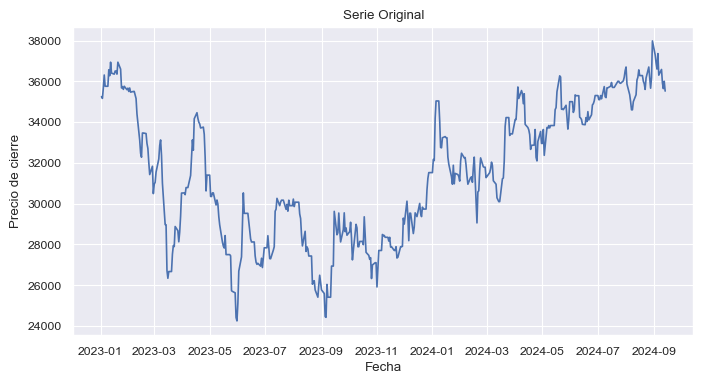

In [10]:
# Serie original
sns.set_theme()
sns.set_context("paper")
sns.lineplot(data = data, x = data.date, y = data.adjclose);
plt.title('Serie Original')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.show()

La gráfica muestra la evolución del precio de cierre del los activos de Bancolombia S.A. a lo largo del tiempo, desde inicios de 2023 hasta septiembre de 2024. A lo largo de este período, el precio ha experimentado fluctuaciones significativas. A principios de 2023, el precio fue alto, seguido de una caída pronunciada en los meses posteriores hasta mediados de 2023. Luego, el precio se estabilizó y comenzó una tendencia alcista en 2024, alcanzando niveles máximos cercanos a septiembre de 2024.

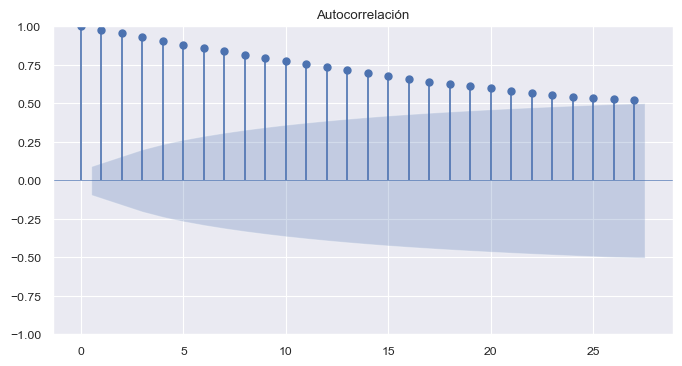

In [11]:
# Autocorrelación
# Lag: observación de una variable en un momento anterior al momento actual.
plot_acf(data['adjclose'], linewidth = 0.5)  
plt.title('Autocorrelación')
plt.show()

La gráfica muestra la función de autocorrelación (ACF) de una serie temporal. Se observa una autocorrelación positiva significativa en los primeros lags (retrasos), que disminuye gradualmente, pero sigue siendo alta incluso después de varios periodos. Esto indica que la serie temporal tiene una dependencia de largo plazo, lo que sugiere que podría ser no estacionaria, ya que un proceso estacionario tendría una autocorrelación que se desvanece más rápidamente. Este comportamiento sugiere que un modelo ARIMA con diferenciación podría ser apropiado para lograr la estacionariedad.

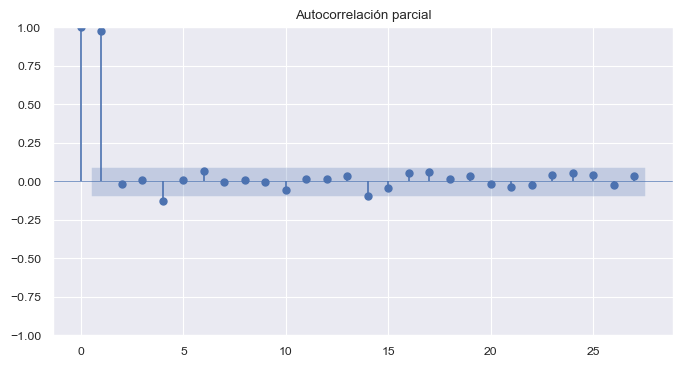

In [12]:
# Autocorrelación Parcial
plot_pacf(data['adjclose'], linewidth = 0.5)  
plt.title('Autocorrelación parcial')
plt.show()

La gráfica muestra la **Función de Autocorrelación Parcial (PACF)**, que refleja la relación directa entre una observación y sus retrasos, eliminando la influencia de los valores intermedios. En este caso, las primeras dos lags tienen autocorrelaciones significativas cercanas a 1, mientras que las demás caen rápidamente hacia cero. Esto indica que la serie tiene un componente autorregresivo de orden bajo, lo que sugiere que un modelo **AR(p)** con \( p \approx 1 o 2 \) podría ser adecuado para modelar el comportamiento de la serie.

### Prueba de Dicker-Fluyer aumentada

Para llegar a la conclusión de que la serie no es estacionaria utilizando la prueba de Dickey-Fuller aumentada (ADF), se sigue este razonamiento:

1. **Hipótesis nula (H0)**: La serie tiene una raíz unitaria, es decir, **no es estacionaria**.
2. **Hipótesis alternativa (H1)**: La serie es estacionaria.

El resultado de la prueba nos da un **ADF Statistic** y un **p-value**. Si el **p-value** es mayor que un nivel de significancia común (generalmente 0.05), no se puede rechazar H0, lo que indica que la serie no es estacionaria.

En este caso, el **p-value** de 0.153398 es mayor que 0.05, por lo que no podemos rechazar H0 y concluimos que la serie no es estacionaria.

In [13]:
adf_result = adfuller(data["adjclose"].tolist())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: -2.359825
p-value: 0.153398


Se muestran los resultados de una prueba de Dickey-Fuller aumentada (ADF), que se usa para verificar la estacionariedad de una serie temporal. El valor del ADF Statistic es -2.359825 y el p-value es 0.153398.

Dado que el p-value es mayor que 0.05, no se puede rechazar la hipótesis nula de que la serie tiene una raíz unitaria, lo que sugiere que la serie no es estacionaria. Para hacerla estacionaria, se podría considerar realizar una diferenciación (por ejemplo, un modelo ARIMA con un componente de diferenciación).

### Descomposición estacionario:

Se realiza la descomposición estacional de una serie temporal (en este caso, el precio ajustado de cierre, "adjclose") en sus componentes: tendencial, estacional, y residual (ruido). Usa el modelo aditivo con un período estacional de 20 días.

- Componente original: la serie completa.
- Componente tendencial: muestra la tendencia a largo plazo.
- Componente estacional: capta los ciclos recurrentes cada 20 días.
- Componente residual: captura las variaciones aleatorias o ruido.
Esta descomposición ayuda a analizar cada parte de la serie temporal por separado para identificar patrones.

In [14]:
decompose_model = seasonal.seasonal_decompose(data["adjclose"].tolist(),period = 20, model = 'additive')
# El comportamiento de la serie tiene un ciclo estacional que se repite cada 20 días.

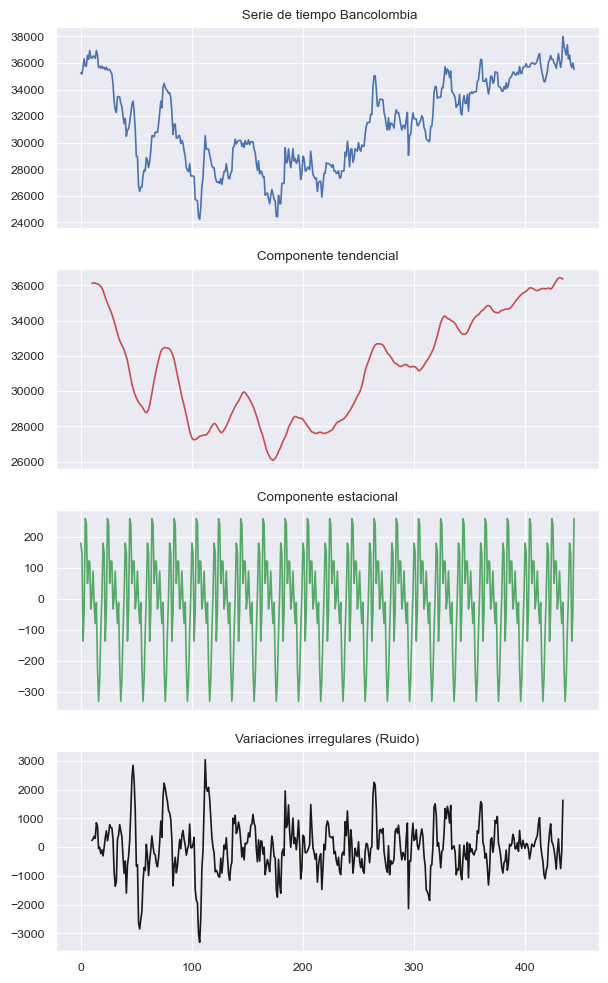

In [15]:
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(7, 12)
sns.set_theme()
sns.set_context("paper")

data['adjclose'].plot(ax = axarr[0], color = 'b', linestyle = '-')
axarr[0].set_title(' Serie de tiempo Bancolombia')

pd.Series(data = decompose_model.trend, index = data.index).plot(color = 'r', linestyle='-', ax=axarr[1])
axarr[1].set_title('Componente tendencial')

pd.Series(data = decompose_model.seasonal, index = data.index).plot(color = 'g', linestyle = '-', ax=axarr[2])
axarr[2].set_title('Componente estacional')

pd.Series(data = decompose_model.resid, index = data.index).plot(color = 'k', linestyle = '-', ax=axarr[3])
axarr[3].set_title('Variaciones irregulares (Ruido)');

Las graficas muestras el resumen de la descomposición estacionaria:

1. **Serie original**: Esta gráfica muestra el comportamiento general de la serie temporal (precio ajustado de Bancolombia). Observamos una gran volatilidad, con caídas significativas entre principios y mediados de 2023, seguidas de una recuperación hacia 2024. El precio fluctúa entre 24,000 y 38,000.

2. **Componente tendencial**: Muestra la tendencia subyacente a largo plazo. Aquí se observa que, tras una fuerte caída inicial, hay una recuperación sostenida. La tendencia nos ayuda a identificar el comportamiento a largo plazo sin la interferencia de fluctuaciones diarias o estacionales.

3. **Componente estacional**: Representa los patrones cíclicos recurrentes que se repiten cada 20 días. Estas fluctuaciones estacionales son regulares, lo que indica un patrón estacional claro en la serie. Este componente puede ser útil para predecir ciclos a corto plazo.

4. **Variaciones irregulares (Ruido)**: Esta gráfica muestra las variaciones que no pueden ser explicadas por la tendencia o los patrones estacionales. Estas variaciones representan el "ruido" o componentes aleatorios, y parecen tener cierta volatilidad. La ausencia de un patrón claro en este componente indica que estos movimientos no son predecibles con base en los otros factores.

En conjunto, la descomposición estacional permite analizar la serie temporal separando sus componentes clave: la tendencia a largo plazo, los ciclos estacionales recurrentes y las variaciones aleatorias, lo que ayuda a entender mejor los movimientos del precio de la acción y facilita la predicción y modelado de futuros valores.

Se realiza la prueba de **Dickey-Fuller aumentada (ADF)** sobre el **componente residual** de la descomposición estacional de la serie temporal. Utiliza el método `adfuller` para verificar si las **variaciones irregulares (residuales)** son estacionarias, eliminando valores infinitos con `np.where`.

In [16]:
adf_result = adfuller(decompose_model.resid[np.where(np.isfinite(decompose_model.resid))[0]], autolag = 'AIC')
print('p-valor:', adf_result[1])

p-valor: 1.846244825117788e-17


El resultado de la prueba es un **p-valor extremadamente pequeño**: 1.846236182457774e-17, lo que indica que se puede rechazar la hipótesis nula de la prueba (que implica no estacionariedad). Esto significa que las variaciones residuales son **estacionarias**, es decir, no presentan una tendencia ni estacionalidad.

### Prueba de normalidad

Se reemplazan valores infinitos por NaN en los residuales, luego los limpia, y se realiza la prueba de Shapiro-Wilk (shapiro(resid_clean)) para verificar si los residuales siguen una distribución normal. El resultado muestra un p-valor de 0.000, lo que indica que podemos *rechazar la hipótesis nula de normalidad* (es decir, los residuales no siguen una distribución normal).

In [17]:
decompose_model = seasonal.seasonal_decompose(data["adjclose"].tolist(),period = 20, model = 'additive')
resid_clean = decompose_model.resid
resid_clean = np.where(np.isinf(resid_clean), np.nan, resid_clean)  # Reemplazar infinitos por NaN
resid_clean = resid_clean[~np.isnan(resid_clean)]  # Eliminar los NaN

# Reemplaza los valores infinitos por NA y luego elimina los NA
stat , p = shapiro(resid_clean)
print('Statistics = %.3f, p = %.3f' % (stat, p))

Statistics = 0.973, p = 0.000


Se genera un gráfico Q-Q para visualizar si los residuales se ajustan a una distribución normal. En este gráfico, si los puntos siguen la línea diagonal, los datos siguen una distribución normal; si no, se desvían de ella.

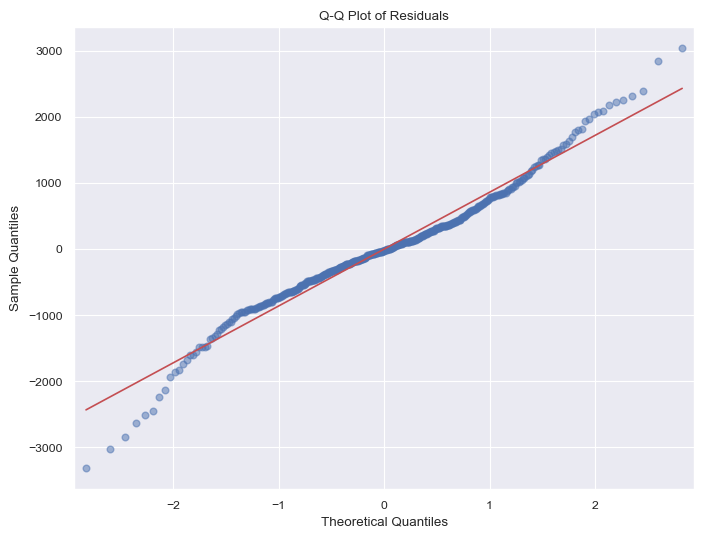

In [18]:
decompose_model = seasonal.seasonal_decompose(data['adjclose'], period=20, model='additive')
plt.rcParams.update({'figure.figsize': (8, 6)})
fig = sm.qqplot(decompose_model.resid.dropna(), line='s', alpha=0.5, color='b', lw=2)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

Este es un gráfico que compara los cuantiles teóricos de una distribución normal con los cuantiles muestrales de los residuos de la descomposición de la serie temporal de la base de datos de Bancolombia. En el gráfico, los puntos se alinean bastante bien con la línea roja diagonal, lo que sugiere que los residuos siguen en su mayoría una distribución normal. Sin embargo, en los extremos (colas), los puntos se desvían de la línea, lo que indica la presencia de valores atípicos o posibles colas más pesadas en la distribución. Dando asi un indicio de normalidad significativa.

### Modelos ARIMA

El objetivo del modelo ARIMA es ayudar a seleccionar un modelo ARIMA adecuado para la serie temporal, evaluando si necesita ser diferenciada para lograr estacionariedad y determinando los órdenes 
𝑝
p (autorregresivo) y 
𝑞
q (media móvil) mediante la observación de las gráficas de ACF y PACF.

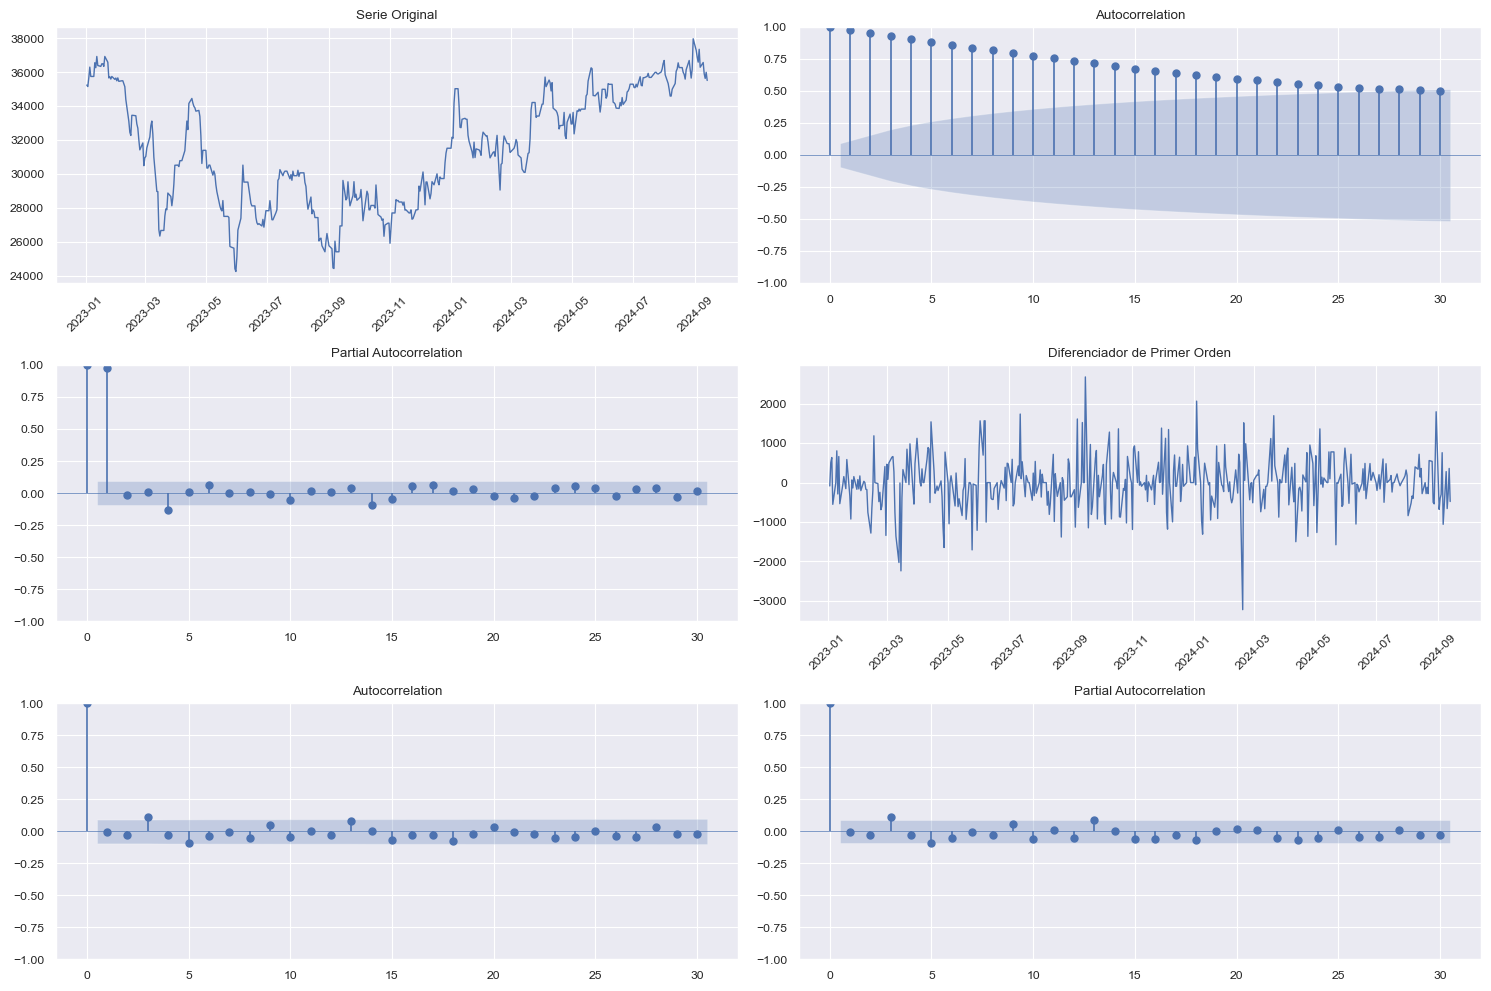

In [19]:
plt.rcParams.update({'text.usetex'     : False})
plt.rcParams.update({'figure.figsize'  : (15, 10)})

nlag = 30
fig, axes = plt.subplots(3, 2, sharex = False) 

# Serie Original
axes[0, 0].plot(data['date'], data['adjclose'], linewidth = 1)  
axes[0, 0].set_title('Serie Original')
plot_acf(data["adjclose"], lags = nlag, linewidth = 0.5, ax = axes[0, 1])
plot_pacf(data["adjclose"], lags = nlag, linewidth = 0.5, ax = axes[1, 0])  

# Diferenciador de Primer Orden
axes[1, 1].plot(data["date"], data['adjclose'].diff(), linewidth = 1) 
axes[1, 1].set_title('Diferenciador de Primer Orden')
plot_acf(data["adjclose"].diff().dropna(), lags = nlag, linewidth = 0.5, ax = axes[2, 0])  
plot_pacf(data["adjclose"].diff().dropna(), lags = nlag, linewidth = 0.5, ax = axes[2, 1]) 

# Rotar los valores del eje x solo para las gráficas de las series temporales
for ax in [axes[0, 0], axes[1, 1]]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

plt.tight_layout()
plt.show()


Aqui se muestra varios análisis clave relacionados con un modelo ARIMA para una serie temporal:

- Serie Original: La serie temporal sin transformar muestra grandes fluctuaciones, lo que sugiere que no es estacionaria.
Autocorrelación (ACF): Los valores de autocorrelación caen lentamente, lo que indica no estacionariedad. La serie muestra dependencias de largo plazo.
- Autocorrelación Parcial (PACF): Solo los primeros retardos son significativos, sugiriendo un posible modelo AR de bajo orden.
- Diferenciación de Primer Orden: La serie diferenciada parece más estable y menos volátil, indicando que podría haber alcanzado estacionariedad.
- ACF y PACF de la serie diferenciada: La ACF muestra un rápido decaimiento, lo que indica que la serie diferenciada puede ser estacionaria y un modelo MA podría ser adecuado.

Con esto se puede concluir que:

   - La serie original es no estacionaria y presenta tendencias. Después de aplicar la diferenciación de primer orden, la serie parece volverse estacionaria. 
   - Con base en las gráficas ACF y PACF, parece adecuado un modelo **ARIMA(1,1,1)** o alguna variación de bajo orden. La diferenciación de primer orden (\(d=1\)) ayuda a estabilizar la media, mientras que la PACF y ACF indican componentes AR y MA de bajo orden.
   - El uso de estas herramientas es clave para modelar series temporales como las que se basan en **procesos estocásticos** y predecir valores futuros con mayor precisión.

There is a lot more that you can do with outputs (such as including interactive outputs)
with your book. For more information about this, see [the Jupyter Book documentation](https://jupyterbook.org)

### Diferenciación de primer orden

In [20]:
adjclose_diff = data["adjclose"].diff().dropna()
adf_result2 = adfuller(adjclose_diff)
print('ADF Statistic: %f' % adf_result2[0])
print('p-value: %f' % adf_result2[1])

ADF Statistic: -11.002471
p-value: 0.000000


Se realiza una diferenciación de primer orden de la serie temporal de precios ajustados y luego aplica la prueba de Dickey-Fuller aumentada (ADF) para verificar la estacionariedad de la serie diferenciada.

Diferenciación: Elimina la tendencia en la serie temporal original para obtener una serie más estable, lo cual es clave para hacer la serie estacionaria.
Prueba ADF: Con un ADF Statistic de -11.002470 y un p-valor de 0.000000, se rechaza la hipótesis nula, lo que indica que la serie diferenciada es estacionaria. Esto confirma que el proceso de diferenciación ha logrado estabilizar la serie temporal.

## Criterios AIC, BIC y HQIC

El conjunto de entrenamiento se utiliza para ajustar el modelo ARIMA o cualquier otro modelo predictivo, mientras que el conjunto de prueba se reserva para evaluar el rendimiento del modelo. Al dividir los datos, se asegura que el modelo se evalúe sobre datos que no ha visto durante el entrenamiento, lo que permite una evaluación más objetiva de su capacidad predictiva.

In [21]:
n_data = len(data.adjclose)
n_test = 30
train_size = n_data - n_test


In [22]:
train = data.adjclose[:train_size]
dates_train = data.date[:train_size]

test = data.adjclose[train_size:train_size + n_test] 
dates_test = data.date[train_size:train_size + n_test] 

print("Train:", train.shape)
print("Test_4w:", test.shape)

Train: (415,)
Test_4w: (30,)


Se dividen los datos en un conjunto de entrenamiento y un conjunto de prueba para análisis y validación de un modelo de series temporales.

Se define el tamaño total de los datos y se reserva un subconjunto de 30 observaciones para prueba.
Los datos restantes (415 observaciones) se utilizan para entrenamiento.
El conjunto de entrenamiento (train) contiene los valores de precios ajustados hasta el índice 415, mientras que el conjunto de prueba (test_4w) contiene los siguientes 30 valores.
El objetivo es probar el modelo sobre los últimos 30 datos, tras haberlo entrenado con los anteriores.

In [23]:
train_df = data[["adjclose"]][:train_size]
test_df = data[["adjclose"]][train_size:train_size + n_test] 

In [24]:
best_aic = np.inf
best_bic = np.inf

best_order = None
best_mdl = None

pq_rng = range(5)
d_rng  = range(3)

for p in pq_rng:
    for d in d_rng:
        for q in pq_rng:
            try:
                tmp_mdl = ARIMA(train, order = (p,d,q)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (p, d,q)
                    best_mdl = tmp_mdl
            except: continue

Este código busca el mejor modelo ARIMA ajustando diferentes combinaciones de 
𝑝
p, 
𝑑
d, y 
𝑞
q, que son los parámetros autorregresivo, diferenciación y de media móvil respectivamente. Para cada combinación, ajusta un modelo ARIMA sobre el conjunto de entrenamiento y calcula el AIC. Si el AIC de una combinación es más bajo que el anterior mejor, actualiza el mejor modelo. El objetivo es identificar el modelo ARIMA que minimice el AIC, lo que indica un equilibrio óptimo entre ajuste y complejidad del modelo.

In [25]:
print('Mejores parámetros ARIMA según AIC:\n')
print('AIC: {:6.5f} | Orden: {}'.format(best_aic, best_order))

Mejores parámetros ARIMA según AIC:

AIC: 6540.04247 | Orden: (0, 1, 3)


el mejor valor de AIC encontrado y los parámetros 
𝑝
,
𝑑
,
𝑞
p,d,q correspondientes. En este caso, el mejor modelo tiene un AIC de 6540.04241 y el orden 
(
0
,
1
,
3
)
(0,1,3).

In [26]:
modelo = ARIMA(train, order = best_order)
modelo_fit = modelo.fit()

Se ajusta el modelo ARIMA utilizando los mejores parámetros encontrados anteriormente. El modelo se ajusta a los datos de entrenamiento y genera un objeto que se puede usar para hacer predicciones.

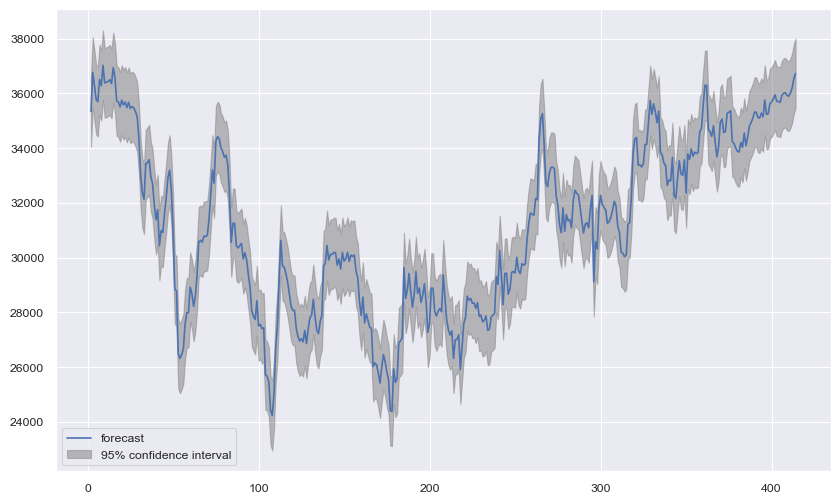

In [27]:
plt.rcParams.update({'figure.figsize': (10,6)})
plot_predict(modelo_fit, 2);
plt.show();

La gráfica muestra la predicción del modelo ARIMA ajustado (línea azul) junto con el intervalo de confianza del 95% (área sombreada en gris). La línea azul sigue de cerca las fluctuaciones de los datos históricos, indicando que el modelo ajusta bien los patrones de la serie. Los intervalos de confianza son más amplios en ciertas áreas, lo que refleja mayor incertidumbre en las predicciones. En general, la gráfica sugiere que el modelo captura las tendencias, pero existe variabilidad que se refleja en la amplitud del intervalo de confianza.

## Rolling Forecast

Se implementa una función para medir la precisión del modelo de pronóstico utilizando varias métricas. Es importante evaluar el rendimiento del modelo con datos reales para asegurar que las predicciones sean confiables. Las métricas utilizadas permiten medir la precisión y el error en distintos aspectos.

- MAPE: Error porcentual absoluto medio, mide el error relativo promedio.
- MAE: Error absoluto medio, mide la magnitud media de los errores.
- RMSE y MSE: Miden la desviación entre valores pronosticados y reales (RMSE es la raíz cuadrada de MSE).
- R²: Coeficiente de determinación, mide qué tan bien el modelo ajusta los datos.

In [28]:
def forecast_accuracy(forecast, actual, str_name):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) 
    mae = np.mean(np.abs(forecast - actual))                 
    rmse = np.mean((forecast - actual)**2)**.5               
    mse = np.mean((forecast - actual)**2)                    
    r2 = r2_score(forecast, actual)
    
    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])
    
    return df_acc

Este conjunto de métricas proporciona una visión integral del rendimiento del modelo de predicción, permitiendo identificar tanto la magnitud del error como la calidad del ajuste del modelo. Al usarlas, se puede evaluar si el modelo es adecuado o si necesita mejoras.

In [29]:
def arima_rolling(history, test):
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions

Se realiza una predicción rolling utilizando el modelo ARIMA, donde para cada punto en el conjunto de prueba, el modelo se ajusta nuevamente con los datos históricos y realiza una predicción. Con cada iteración, la predicción se compara con el valor real, se almacena, y se añade al conjunto de entrenamiento. Este enfoque simula un escenario de predicción en tiempo real, donde los nuevos datos se usan inmediatamente para actualizar el modelo, lo que permite medir el rendimiento continuo del modelo ARIMA.

In [30]:
test_4wl = test.tolist()
yhat_4w  = arima_rolling(train.tolist(), test_4wl)

predicted=35892.135829, expected=35340.000000
predicted=35339.437457, expected=35000.000000
predicted=34897.169791, expected=34600.000000
predicted=34533.326358, expected=34600.000000
predicted=34559.442819, expected=35000.000000
predicted=34973.307244, expected=35340.000000
predicted=35357.803135, expected=36060.000000
predicted=36120.119367, expected=36200.000000
predicted=36252.990186, expected=36560.000000
predicted=36639.381921, expected=36280.000000
predicted=36291.257169, expected=36280.000000
predicted=36305.350562, expected=36000.000000
predicted=35958.943827, expected=35880.000000
predicted=35871.869225, expected=35600.000000
predicted=35563.383567, expected=36160.000000
predicted=36151.183799, expected=36700.000000
predicted=36688.514184, expected=36200.000000
predicted=36269.069769, expected=35660.000000
predicted=35702.746383, expected=36180.000000
predicted=36123.131885, expected=37980.000000
predicted=37946.173838, expected=37300.000000
predicted=37362.673792, expected=3

Se ejecuta una predicción rolling con un modelo ARIMA para cada punto en el conjunto de prueba. Para cada valor en test_4w, se predice el valor futuro (almacenado en yhat_4w) y se compara con el valor esperado. En la salida, se muestran los valores predichos junto a los valores esperados, permitiendo comparar el rendimiento del modelo. Este proceso permite evaluar si el modelo ARIMA está prediciendo correctamente las tendencias y niveles de la serie temporal en datos no utilizados durante el entrenamiento.

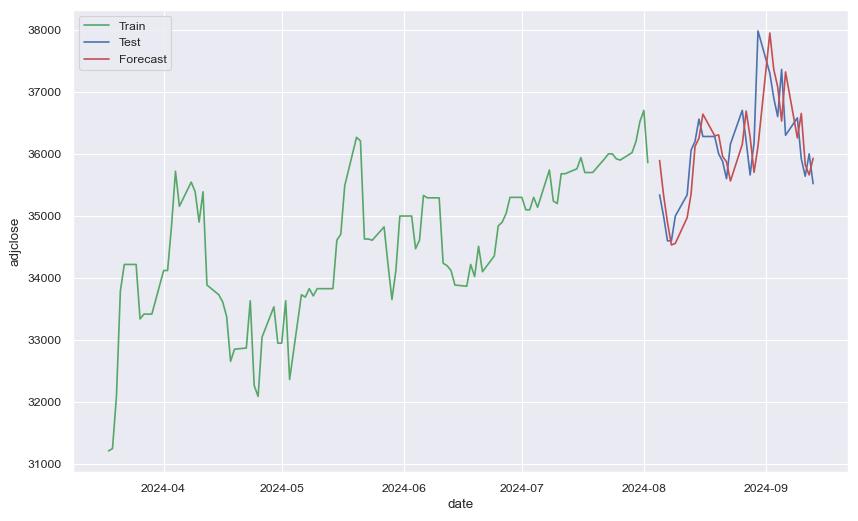

In [31]:
ax = sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g')
sns.lineplot(x=dates_test, y=test_4wl, label="Test", color='b')
sns.lineplot(x=dates_test, y=yhat_4w, label="Forecast", color='r')
plt.show()

La gráfica representa el proceso de Rolling Forecast utilizando un modelo ARIMA para predecir los valores de una serie temporal en función de los datos anteriores. **El entrenamiento (verde)** muestra los valores históricos usados para ajustar el modelo.El
**Test (azul)** representa los valores reales no vistos por el modelo durante el entrenamiento. La
**Predicción (rojo)** son las predicciones generadas por el modelo para los puntos de prueba.

Se observa que el modelo sigue bastante bien las fluctuaciones de los valores reales, lo que indica que capta correctamente las tendencias y patrones a corto plazo. Sin embargo, en algunos puntos se ven pequeñas desviaciones, lo que refleja las limitaciones en la precisión.